<a href="https://colab.research.google.com/github/raeubaen/giagu/blob/master/NB_PCA_tSNE_LC1_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizzazione di dataset con PCA e tSNE

### Informazioni ###

scopo: impratichirsi con le operazioni di data-esploration utilizzando le tecniche di riduzione dimensionale PCA e tSNE.

**Il dataset MNIST**

Il dataset [MNIST](http://yann.lecun.com/exdb/mnist/) è uno dei dataset di bechmark più utlizzati nel ML. Prodotto da Yann LeCun che ha collezionato 70000 immagini di numeri scritti a mano (60000 per il training e 10000 per test). Ogni immagine è rappresentata da una matrice di 28x28 pixel oguno con una intensità nel range $[0,255]$ che rappresenta 256 variazioni del livello di grigio di quel pixel. 

In [1]:
#import delle librerie necessarie
import time
import numpy as np
from sklearn.manifold import TSNE

### Parte 1: load del dataset MNIST e data preprocessing

questo è disponibile vari frameowrk per ML noi utilizzeremo Tensorflow ...

In [2]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#convertiamo i dati in f32 e normalizziamo in [0,1] --> usiamo solo il campione di training in questo esempio
Y = y_train
print(x_train.shape, Y.shape) #output 

(60000, 28, 28) (60000,)


In [3]:
# per comodità convertiamo le matrici che rappresentano i dati in un dataframe di pandas
import pandas as pd

# rendiamo flat le matrici
X = np.reshape(x_train.astype('float32')/255, (60000,28*28))

feat_cols = ['pixel' + str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feat_cols)
df['y'] = Y
df['label'] = df['y'].apply(lambda i: str(i))
X, Y = None, None #frees memory
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (60000, 786)


In [4]:
# randomizziamo i dati (sempre buona cosa)

# For reproducability of the results
np.random.seed(1234)
rndperm = np.random.permutation(df.shape[0])
print(rndperm) #riordinamento dei numeri da 0 a 59999

[30329 44957 30866 ... 34086 58067 27439]


<Figure size 432x288 with 0 Axes>

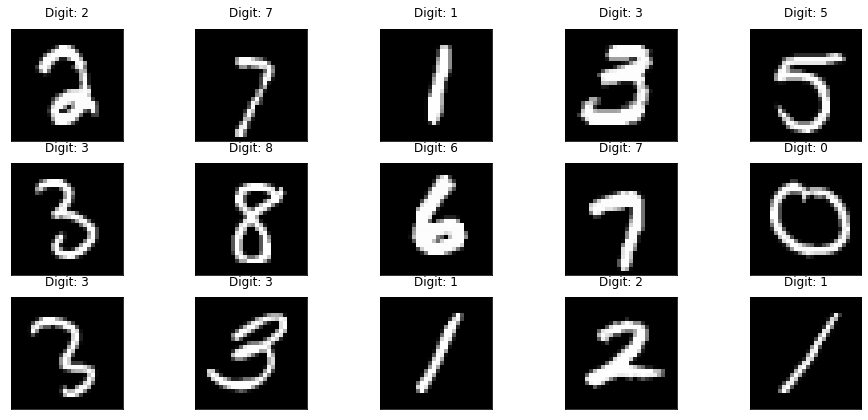

In [30]:
# Esempio di come con Pandas è semplice graficare un dataset ...
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i], feat_cols].values.reshape((28,28)).astype(float))
    ax.set(xticks=[], yticks=[])
plt.show()

### Parte 2: PCA 

utilizzeremo l'implementazione PCA disponibile dentro scikit-learn

In [6]:
from sklearn.decomposition import PCA

#consideriamo solo le prime tre componenti
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#NOTA: l'explained variation indica quanto ciascuna componente contribusice alla varianza totale del campione

Explained variation per principal component: [0.0970472  0.07095964 0.0616912 ]


In [8]:
#df

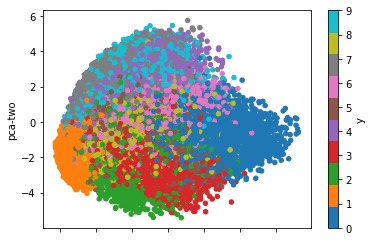

In [9]:
#grafichiamo le prime due componenti
# per fare questo facciamo uno scatter plot delle due componenti e coloriamo ciaascun tipo di carattere con un 
# colore diverso ... questo può essere fatto direttamente usando Pandas!

ax = df.loc[rndperm,:].plot.scatter(x="pca-one", y="pca-two", c="y", colormap='tab10')

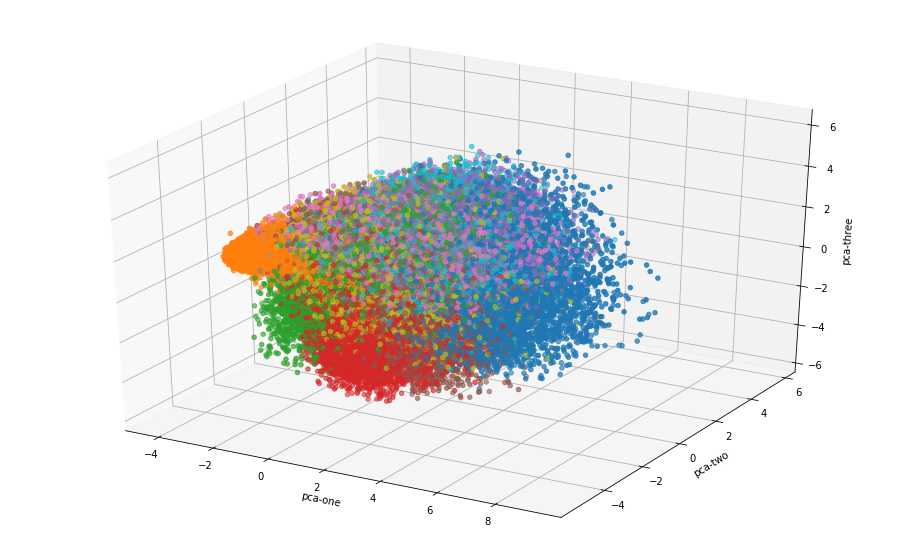

In [10]:
#3d usando matplotlib ...
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### Parte 3: tSNE

utilizzeremo l'implementazione tSNE disponibile dentro scikit-learn

NOTA: tSNE è molto pesante dal punto di vista computazionale (CPU e RAM) con complessità che scala quadraticamente con il numero di eventi nel campione. L'applicabilità è limitata quindi a dataset di qualche migliaio di eventi, oppure bisogna prima di usarlo ridurre la dimensionalità con PCA (esempio $28\times 28 \to $ PCA $\to 25 \to$ tSNE, oppure usare meno campioni.

In questo caso usiamo tutte le 28x28 "features" ma usiamo solo 10k eventi.

In [28]:
# tSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 195.75775742530823 seconds


In [7]:
# selezioniamo i primi 10k eventi dal dataframe 
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

# calcoliamo di nuovo la PCA per confrontarci con tSNE
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09691511 0.07081617 0.06273941]


In [29]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

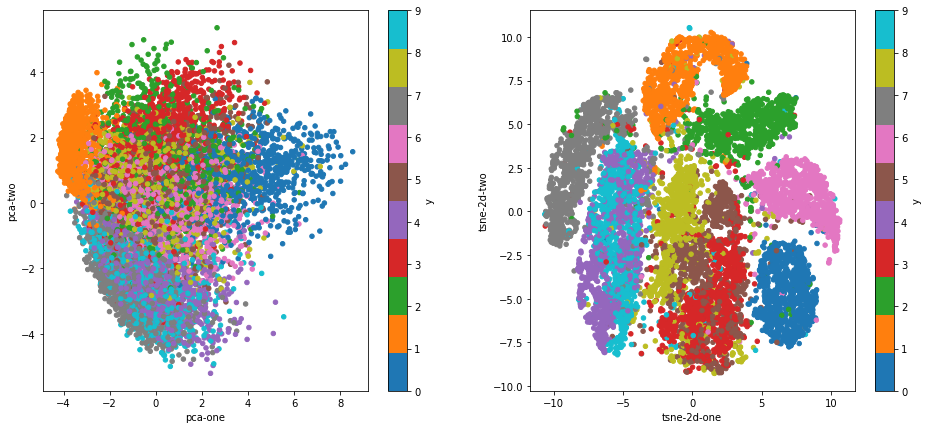

In [30]:
#confrontiamo i risultati PCA vs tSNE
plt.figure(figsize=(16,7))

ax1 = plt.subplot(1, 2, 1)
df_subset.plot.scatter(x="pca-one", y="pca-two", c="y", colormap='tab10', ax=ax1)

ax2 = plt.subplot(1, 2, 2)
df_subset.plot.scatter(
    x="tsne-2d-one", y="tsne-2d-two", c="y", colormap='tab10', ax=ax2,
)


In [ ]:
#plottiamo separatamente i grafici per le singole cifre
fig= plt.figure(figsize=(20, 7))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1, title="Digit: {}".format(i))
    where = (df_subset['y'] == i)
    df_taken = df_subset[where]
    df_taken.plot.scatter(
        x="tsne-2d-one", y="tsne-2d-two", 
        c=df_taken["y"], colormap='tab10',
        ax=ax, vmin=0, vmax=9, xticks=[]
    )                          

Procediamo ora a utilizzare il metodo di clustering GaussianMixture sull'output della TSNE applicata una piccola parte del dataset. Riduciamo il numero di samples a 3000 e rieseguiamo la TSNE riducendo la perplexity. 

In [92]:
from sklearn.mixture import GaussianMixture
df_micro = df_subset.head(2000).copy()

data_micro = df_micro[feat_cols].values

tsne = TSNE(n_components=2, verbose=3, perplexity=50, n_iter=1000) 
tsne_results = tsne.fit_transform(data_micro)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.056s...
[t-SNE] Computed neighbors for 2000 samples in 7.168s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.687701
[t-SNE] Computed conditional probabilities in 0.165s
[t-SNE] Iteration 50: error = 71.7794495, gradient norm = 0.0086436 (50 iterations in 2.722s)
[t-SNE] Iteration 100: error = 71.7790756, gradient norm = 0.0063402 (50 iterations in 2.173s)
[t-SNE] Iteration 150: error = 71.6032257, gradient norm = 0.0137707 (50 iterations in 1.180s)
[t-SNE] Iteration 200: error = 71.1031113, gradient norm = 0.0096011 (50 iterations in 0.830s)
[t-SNE] Iteration 250: error = 71.0863113, gradient norm = 0.0111016 (50 iterations in 0.736s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.086311
[t-SNE] Iteration 300: error = 1.4185411, gradient norm = 0.0012011 (50 iterations in 0.978s

In figura si vede l'output della TSNE. <br>

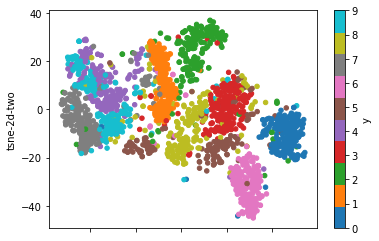

In [97]:
df_micro['tsne-2d-one'] = tsne_results[:,0]
df_micro['tsne-2d-two'] = tsne_results[:,1]

df_micro.plot.scatter(x="tsne-2d-one", y="tsne-2d-two", c="y", colormap='tab10')

tsne_x, tsne_y = df_micro["tsne-2d-one"], df_micro["tsne-2d-two"]
train = np.transpose([tsne_x, tsne_y])
n_components = 10
labels = [0]*n_components

gmm = GaussianMixture(n_components=n_components, max_iter=1000).fit(
    train
)

L'output della tSNE mostra che i punti sono ben separati (a parte il 4 e il 9), seppur la distanza tra i cluster è piccola.
Osserviamo ora i singoli cluster trovati, assegnando ad ognuno la cifra più frequente.

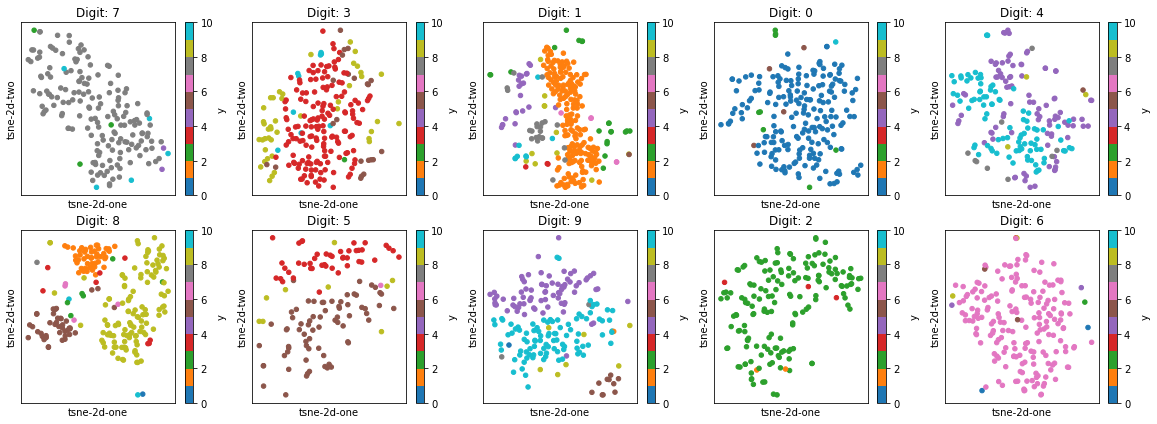

In [98]:
df_micro["predictions"] = gmm.predict(train)

fig = plt.figure(figsize=(20, 7*np.ceil(n_components/10)))
for i in range(n_components):
    where = (df_micro['predictions'] == i)
    df_taken = df_micro[where]
    labels[i] = int(df_taken['y'].mode()[0])
    ax = fig.add_subplot(np.ceil(n_components/5),5,i+1, title="Digit: {}".format(labels[i]))
    df_taken.plot.scatter(
        x="tsne-2d-one", y="tsne-2d-two", 
        c="y", colormap='tab10',        ax=ax, vmin=0, vmax=n_components, xticks=[], yticks=[],
    )

Mostriamo ora l'output della TSNE e le regioni di confidenza in 2 $\sigma$ delle gaussiane trovate.

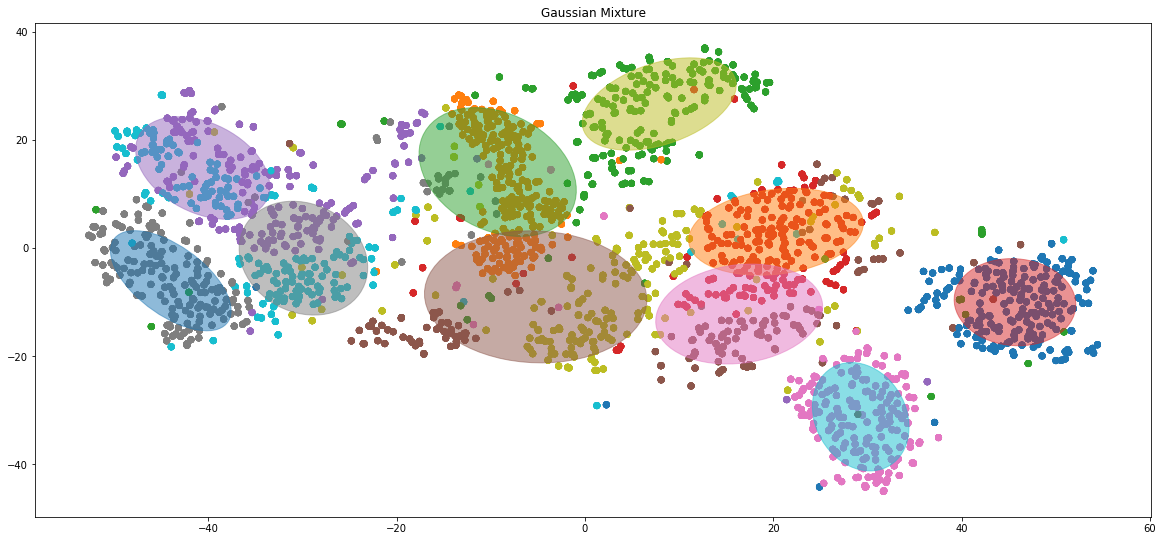

In [99]:
import itertools
from matplotlib import cm, patches
color_iter = itertools.cycle(cm.get_cmap('tab10').colors)
plt.close()
def plot_results(x, y, labels, means, covariances, index, title): #from the docs of sklearn
    fig = plt.figure(figsize=(20, 20))
    splot = fig.add_subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.

        plt.scatter(x, y, c=labels, cmap='tab10', 
            vmin=0, vmax=10,
        )
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.title(title)
    
plot_results(tsne_x, tsne_y, df_micro["y"], gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

Valutiamo l'accuracy sul campione di train.

In [100]:
exc = lambda x: labels[x]
def accuracy(df):
    pred_labels = df["predictions"].copy().apply(exc)
    corrects = pred_labels == df["y"]
    return corrects.sum()/len(df)

print(f"Train accuracy: {accuracy(df_micro)}")

Train accuracy: 0.714


#### Considerazioni: 
Il tSNE è un metodo per la *visualizzazione* e *riduzione dimensionale* dei dati, 
che comporta una notevole perdita di informazioni. <br> Non riteniamo pertando adeguato,
se non in casi fortunati, l'applicazione di un algoritmo di classificazione a partire dall'output 
del tSNE. <br> Si è ottenuta un'accuracy accettabile, ma l'overtraining sui parametri delle gaussiane trovate
è totale. <br> Infatti rieseguendo la tSNE su un altro campione dallo stesso dataset si otterrebbe quasi sicuramente un output
geometricamente diverso, con i cluster posti in punti diversi.

In [59]:
#proviamo PCA + tSNE:

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Cumulative explained variation for 50 principal components: 0.8249903321266174
t-SNE done! Time elapsed: 47.80095720291138 seconds


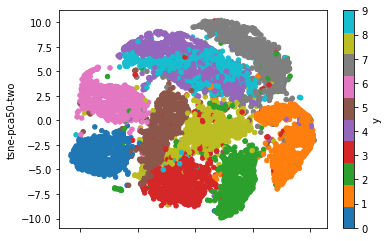

In [60]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]

ax4=df_subset.plot.scatter(x="tsne-pca50-one", y="tsne-pca50-two", c="y", colormap='tab10')

Il risultato di PCA + tSNE è incoraggiante, solo il 4 ed il 9 rimangono non separati.
Proviamo a ripetere l'ultima analisi eliminando le gradazioni di grigio, portando l'immagine in bianco e nero.

<Figure size 432x288 with 0 Axes>

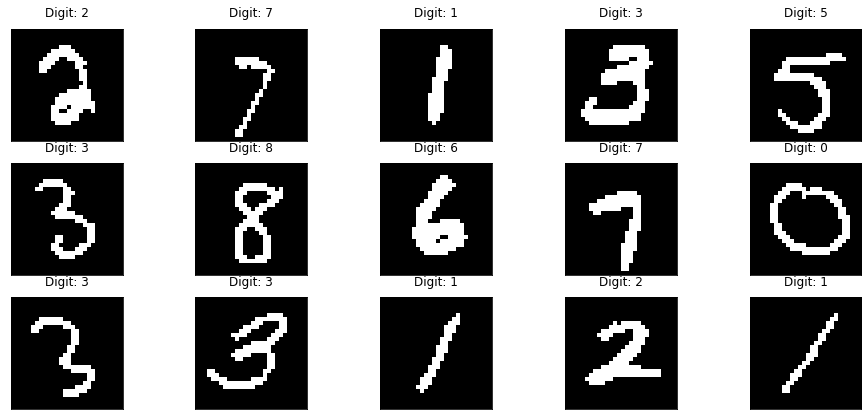

In [61]:
df_bw = df_subset.copy()
df_bw[feat_cols] = (df_bw[feat_cols] > 0.5).astype("int")

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    row = df_bw.iloc[[i]]
    label = int(row['y'])
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(label)) )
    ax.matshow(row[feat_cols].values.reshape((28,28)).astype(float))
    ax.set(xticks=[], yticks=[])
plt.show()

In [ ]:
#proviamo PCA + tSNE:
data_bw = df_bw[feat_cols].values

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_bw)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

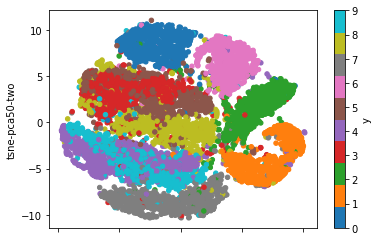

In [67]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]

ax4=df_subset.plot.scatter(x="tsne-pca50-one", y="tsne-pca50-two", c="y", colormap='tab10')

Il risultato è peggiore del caso precedente, la tSNE non è riuscita a separare il 3 ed il 5. Ciò è evidentemente dovuto alla perdita di informazione riguardo i bordi dei numeri avvenuta nel passaggio da scala di grigi a bianco e nero.

Effettuiamo ora l'analisi PCA + tSNE sul dataset SUSY.